## Single-disease IPF Alveolar Fibroblast analysis, figures, marker gene identification

__author__ = "Ciro Ramírez-Suástegui"

__copyright__ = "Copyright 2022-09-15, Helmholtz Zentrum Muenchen"

__license__ = "GPL"

__version__ = "0.0.9"

__email__ = "ciro.suastegui@helmholtz-muenchen.de, ksuasteguic@gmail.com"

__status__ = "Prototype"

#### Structure

* [Global variables and paths](#bullet1)
* [Loading data](#bullet2)
* [Pre-processing](#bullet3)
* [Main](#bullet4)
* [Conclusions](#bullet5)
* [Save](#bullet6)

### Environment setup

In [1]:
# %load_ext autoreload
# %autoreload 2
import importlib

In [2]:
spam_spec = importlib.util.find_spec("lab_black")
if spam_spec is not None:
    %load_ext lab_black

In [3]:
# basic modules
import warnings, os, re
import time, sys
from datetime import datetime
import pickle

In [4]:
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [5]:
# in-house/developing modules
# tools modules
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys

sys.path.append("../../scripts/")
import analysis

In [6]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
7b32b9a39ad70713acde__mypyc NA
PIL                         9.2.0
analysis                    NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
black                       22.6.0
blib2to3                    NA
cffi                        1.15.1
click                       8.1.3
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.2
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
h5py                        3.7.0
igraph                      0.9.11
ipykernel                   6.15.1
ipython_genutils            0.2.0
jedi                        0.18.1
joblib                      1.1.0
jupyter_server              1.18.1
kiwisolver                  1.4.4
lab_black                   NA
leidenalg                   0.8.10
llvmlite                    0.39.0
matplotlib    

In [7]:
# # print("Environment:", re.sub(".os.py", "", os.__file__))
# parentpath = lambda _path, n: os.sep.join(_path.split(os.sep)[:-n])
# print("Working at:", re.sub(parentpath(os.getcwd(), 2), "", os.getcwd()))

In [8]:
# setting visualisation parameters
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
fz = 12
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["xtick.labelsize"] = fz
plt.rcParams["ytick.labelsize"] = fz
plt.rcParams["axes.labelsize"] = fz
plt.rcParams["font.size"] = fz
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.grid"] = False

In [9]:
# def make_title(x):
#     return re.sub("[^0-9a-zA-Z\.]+", " ", x).title()

### Global variables and paths <a class="anchor" id="bullet1"></a>

In [10]:
adata_inp = "../../data/HLCA_extended/extension_disease/scarches_emb_ipf_alveolar-fibroblasts.h5ad"
edata_inp = "../../data/HLCA_extended/HLCA_extended/HLCA_extended_full.h5ad"
use_full_matrix = True
if not use_full_matrix:
    edata_inp = "../../data/HLCA_extended/HLCA_extended/extension_data_pooled_raw_2000genes.h5ad"
    cdata_inp = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
path_celltype_colors = "../../supporting_files/celltype_structure_and_colors/manual_anns_grouped_order_and_colors.csv"
path_hlca_full_emb = (
    "../../data/HLCA_extended/HLCA_extended/HLCA_extended_scarches_emb.h5ad"
)
dir_dea_results = "../../results/DEAs/alv_fibs_IPF_cluster/"
dir_figures = "../../results/figures/"

In [11]:
# sc.settings.figdir = "figures/single-disease_" + re.sub(
#     ".*/|scarches_emb_|.h5ad", "", adata_inp + "_full"
# )
# sc.settings.figdir

initiate empty dictionary to store paper figures in:

In [12]:
FIGURES = dict()

### Loading data <a class="anchor" id="bullet2"></a>

Load celltype colors used across paper, for umaps generated at the bottom of this notebook:

In [13]:
celltype_colors = pd.read_csv(path_celltype_colors, index_col=0)

Load ...

In [14]:
embed_disease = sc.read(adata_inp)

In [15]:
%%time
if use_full_matrix:
    print("Using full matrix")
    edata = sc.read(edata_inp, backed="r")
else:
    edata = sc.read(edata_inp)
    cdata = sc.read(cdata_inp)

Using full matrix
CPU times: user 6.31 s, sys: 3.91 s, total: 10.2 s
Wall time: 14.1 s


### Pre-processing <a class="anchor" id="bullet3"></a>

`%%time`

`temp = ["ENSG00000118785.15_SPP1", "ENSG00000095970.17_TREM2", "ENSG00000170323.9_FABP4"]`

`edata_temp = edata[edata.obs["study"] == "Nawijn_2021", temp].to_memory()`

`edata_temp`

Output:

CPU times: user 21 s, sys: 1min 21s, total: 1min 42s

Wall time: 7min 31s

AnnData object with n_obs × n_vars = 70402 × 3

`edata_temp.X.sum(axis=0)`

Output:

matrix([[1334.346 , 1149.7227, 1206.5526]], dtype=float32)

In [16]:
%%time
barcodes = embed_disease.obs_names.intersection(edata.obs_names)
print(f"{len(barcodes)}/{embed_disease.shape[0]}")
if use_full_matrix:
    adata_comb = edata[barcodes].to_memory()
else:
    print("Adding core data")
    xdata0 = edata[barcodes].copy()
    temp = embed_disease.obs_names.intersection(cdata.obs_names)
    print(f"{len(temp)}/{embed_disease.shape[0]}")
    xdata1 = cdata[temp, edata.var_names].copy()
    adata_comb = xdata0.concatenate(xdata1, index_unique=None)

21496/21496
CPU times: user 3.57 s, sys: 16.3 s, total: 19.8 s
Wall time: 4min 34s


In [17]:
adata_comb[:3].obs

,sample,original_celltype_ann,study_long,study,last_author_PI,subject_ID,subject_ID_as_published,pre_or_postnatal,age_in_years,age_range,...,transf_ann_level_1_uncert,transf_ann_level_2_label,transf_ann_level_2_uncert,transf_ann_level_3_label,transf_ann_level_3_uncert,transf_ann_level_4_label,transf_ann_level_4_uncert,transf_ann_level_5_label,transf_ann_level_5_uncert,cellname_original
AGAATAGGTACCCAAT_NML1_tsukui,NML1_Lin,Col1+,nan,Sheppard_2020,nan,NML1,nan,nan,NaN,nan,...,0.0,Fibroblast lineage,0.0,Fibroblasts,0.0,Alveolar fibroblasts,0.000000,4_Alveolar fibroblasts,0.000000,AGAATAGGTACCCAAT_NML1
GAGGTGACAAGGTTCT_NML2_tsukui,NML2_Lin,Col1+,nan,Sheppard_2020,nan,NML2,nan,nan,NaN,nan,...,0.0,Fibroblast lineage,0.0,Fibroblasts,0.0,Alveolar fibroblasts,0.000000,4_Alveolar fibroblasts,0.000000,GAGGTGACAAGGTTCT_NML2
CCTACACTCTTCATGT_IPF2_tsukui,IPF2_Lin,Col1+,nan,Sheppard_2020,nan,IPF2,nan,nan,NaN,nan,...,0.0,Fibroblast lineage,0.0,Fibroblasts,0.0,Alveolar fibroblasts,0.019988,4_Alveolar fibroblasts,0.019988,CCTACACTCTTCATGT_IPF2


Check order

In [18]:
(adata_comb.obs_names == embed_disease.obs_names).all()

True

In [19]:
%%time    
adata_comb = adata_comb[embed_disease.obs_names, :]

CPU times: user 80.3 ms, sys: 9.4 ms, total: 89.7 ms
Wall time: 87.2 ms


In [20]:
temp = [i for i in embed_disease.obs.columns if not i in adata_comb.obs.columns]
df = embed_disease.obs.loc[:, temp]
print(f"Adding {df.shape[1]} more columns")
adata_comb.obs = pd.concat([adata_comb.obs, df], axis=1)
# adata_comb.var = edata.var
adata_comb.obsm = embed_disease[adata_comb.obs_names].obsm

Adding 12 more columns


In [21]:
adata_comb

AnnData object with n_obs × n_vars = 21496 × 59574
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', '

calculate total counts:

In [22]:
adata_comb.obs["total_counts"] = adata_comb.X.sum(axis=1)

In [23]:
adata_comb.obs["log10_total_counts"] = np.log10(adata_comb.obs.total_counts)

Now normalize and log-transform counts:

In [24]:
sc.pp.normalize_total(adata_comb, target_sum=7699)

In [25]:
sc.pp.log1p(adata_comb)

Reduce genes: filter out genes expressed in few cells or genes expressed in a single dataset.

Filtering based on number of cells that express the gene:

In [26]:
adata_comb.shape

(21496, 59574)

In [27]:
sc.pp.filter_genes(adata_comb, min_cells=20)

In [28]:
adata_comb.shape

(21496, 19929)

filter out dataset-specific genes, using groupby:

In [29]:
adata_comb_genedf = pd.DataFrame(
    adata_comb.X.toarray(), index=adata_comb.obs.index, columns=adata_comb.var.index
)

In [30]:
genes = adata_comb_genedf.columns

In [31]:
adata_comb_genedf["study"] = adata_comb.obs["study"]

In [32]:
genedf_study = adata_comb_genedf.groupby("study").agg({gene: "sum" for gene in genes})

In [33]:
gene_in_multiple_studies = (genedf_study > 0).sum(axis=0) > 1
gene_in_multiple_studies = gene_in_multiple_studies.loc[
    gene_in_multiple_studies.values
].index.tolist()

In [34]:
len(gene_in_multiple_studies)

18510

Now filter the adata object:

In [35]:
adata_comb = adata_comb[:, gene_in_multiple_studies].copy()

Sorting some variables out. @Ciro if that's okay I remove all cells below (that I commented out for now)

In [36]:
# pd.crosstab(adata_comb.obs["study"], adata_comb.obs["core_or_extension"])

In [37]:
# pd.crosstab(
#     adata_comb.obs["core_or_extension"],
#     adata_comb.obs["3'_or_5'"],
# )

In [38]:
# pd.crosstab(
#     adata_comb.obs["study"],
#     adata_comb.obs["3'_or_5'"].astype(str).fillna("EMPTY"),
# )

In [39]:
# strand_end = []
# for i in adata_comb.obs.index:
#     scp = adata_comb.obs.loc[i, "single_cell_platform"]
#     try:
#         strand_end.append(re.search(".* ([0-9]+').*", scp).group(1))
#     except AttributeError:
#         strand_end.append(scp)

In [40]:
# adata_comb.obs["strand_end"] = strand_end

In [41]:
# pd.crosstab(
#     adata_comb.obs["strand_end"],
#     adata_comb.obs["3'_or_5'"].astype(str).fillna("EMPTY"),
# )

Reorder cells in adata, so that plotting order of cells in umaps is random:

In [42]:
index_list = adata_comb.obs.index.tolist()
np.random.shuffle(index_list)
adata_comb = adata_comb[index_list, :]

Fixing IPF and healthy (tumor adjacent) because the column was now taken from the full matrix, not the subsetted to this disease and/or cell type. In the latter we had already renamed IPF and tumor adjacent labels. 

In [43]:
adata_comb.obs["condition"].value_counts()
condition_renamer = {i: i for i in adata_comb.obs.condition.cat.categories}
condition_renamer["End-stage lung fibrosis, unknown etiology"] = "IPF"
condition_renamer["Healthy (tumor adjacent)"] = "Healthy"
condition_renamer
adata_comb.obs["condition"] = pd.Categorical(
    adata_comb.obs.condition.map(condition_renamer)
)
adata_comb.obs["condition"].value_counts()

Healthy    16411
IPF         5085
Name: condition, dtype: int64

In [44]:
# condition2color = {"Healthy": "#e4e4e4", "COVID-19": "red", "IPF": "orange"}  # "blue"

### Main <a class="anchor" id="bullet4"></a>

In [45]:
# cluster_columns = list(filter(re.compile("^leiden_0").match, adata_comb.obs.columns))
# cluster_columns
# cluster_columns = ["leiden_0.3"]
# obs_columns = list(
#     set(
#         [
#             "dataset",
#             "core_or_extension",
#             "condition",
#             "sample_type",
#             "single_cell_platform",
#         ]
#     )
#     & set(adata_comb.obs.columns)
# )
# obs_columns

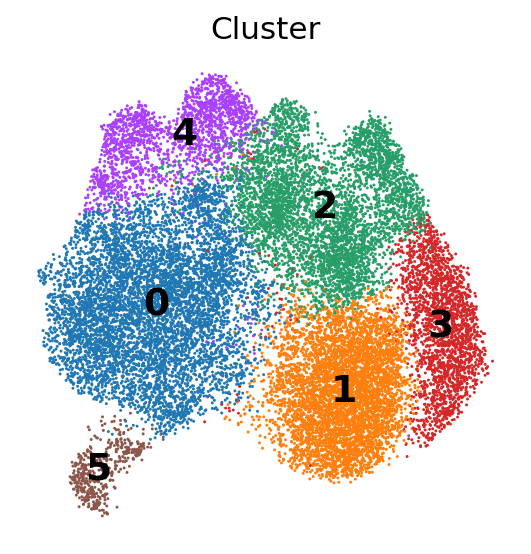

In [46]:
# temp = obs_columns + cluster_columns
# for i in cluster_columns:  # temp:
FIGURES["7b_umap_clusters"] = sc.pl.umap(
    embed_disease,
    color="leiden_0.3",
    size=7,
    frameon=False,
    wspace=0.6,
    return_fig=True,
    title="Cluster",
    legend_fontsize=fz + 5,
    legend_loc="on data",
)

print number of cells per cluster (this info needs to be included in the manuscript, as we do a statistical test on cluster 1:)

In [50]:
n_cluster_0 = embed_disease.obs["leiden_0.3"].value_counts()[0]
print("n cells cluster 0:", n_cluster_0)
print("n cells rest:", embed_disease.n_obs - n_cluster_0)

n cells cluster 0: 6765
n cells rest: 14731


what is this for @Ciro? 

In [47]:
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "last_expr"

Generate variable including study information for IPF datasets, with all other datasets set to healthy:

In [48]:
adata_comb.obs["condition_study"] = [
    f"IPF ({st})" if cond == "IPF" else "Healthy (all studies)"
    for st, cond in zip(adata_comb.obs.study, adata_comb.obs.condition)
]
# sort categories such that healthy is first
adata_comb.obs.condition_study = pd.Categorical(
    adata_comb.obs.condition_study,
    categories=["Healthy (all studies)"]
    + [
        cat
        for cat in sorted(adata_comb.obs.condition_study.unique())
        if not cat.startswith("Healthy")
    ],
)
# adata_comb.obs.condition_study.cat.reorder_categories()

Use same study coloring scheme as for MDM figures in other notebook:

In [49]:
study2color = {
    "Banovich_Kropski_2020": "#FFFF00",
    "Barbry_Leroy_2020": "#1CE6FF",
    "Budinger_2020": "#FF34FF",
    "Duong_lungMAP_unpubl": "#FF4A46",
    "Eils_2020": "#008941",
    "Janssen_2020": "#006FA6",
    "Kaminski_2020": "#A30059",
    "Krasnow_2020": "#FFDBE5",
    "Lafyatis_2019": "#7A4900",
    "Lafyatis_Rojas_2019": "#0000A6",
    "Lambrechts_2021": "#63FFAC",
    "Meyer_2019": "#B79762",
    "Meyer_2021": "#004D43",
    "Meyer_Nikolic_2022": "#8FB0FF",
    "Misharin_2021": "#997D87",
    "Misharin_Budinger_2018": "#5A0007",
    "Peer_Massague_2020": "#809693",
    "Regev_2021": "#6A3A4C",
    "Schiller_2020": "#1B4400",
    "Schiller_2021": "#4FC601",
    "Schultze_unpubl": "#3B5DFF",
    "Shalek_2018": "#4A3B53",
    "Sheppard_2020": "#FF2F80",
    "Sun_2020": "#61615A",
    "Tata_unpubl": "#BA0900",
    "Teichmann_Meyer_2019": "#6B7900",
    "Thienpont_2018": "#00C2A0",
    "Wunderink_2021": "#FFAA92",
    "Xu_2020": "#FF90C9",
    "Zhang_2021": "#B903AA",
}

Make IPF study categories correspond to colors above:

In [50]:
disstudy2color = {  # temp = {
    "Healthy (all studies)": "#e4e4e4",
    "IPF (Sheppard_2020)": study2color["Sheppard_2020"],
    "IPF (Kaminski_2020)": study2color["Kaminski_2020"],
    "IPF (Banovich_Kropski_2020)": study2color["Banovich_Kropski_2020"],
    "IPF (Schiller_2020)": study2color["Schiller_2020"],
    "IPF (Misharin_Budinger_2018)": study2color["Misharin_Budinger_2018"],
}

plot IPF study information barplot:

In [51]:
sc.set_figure_params()

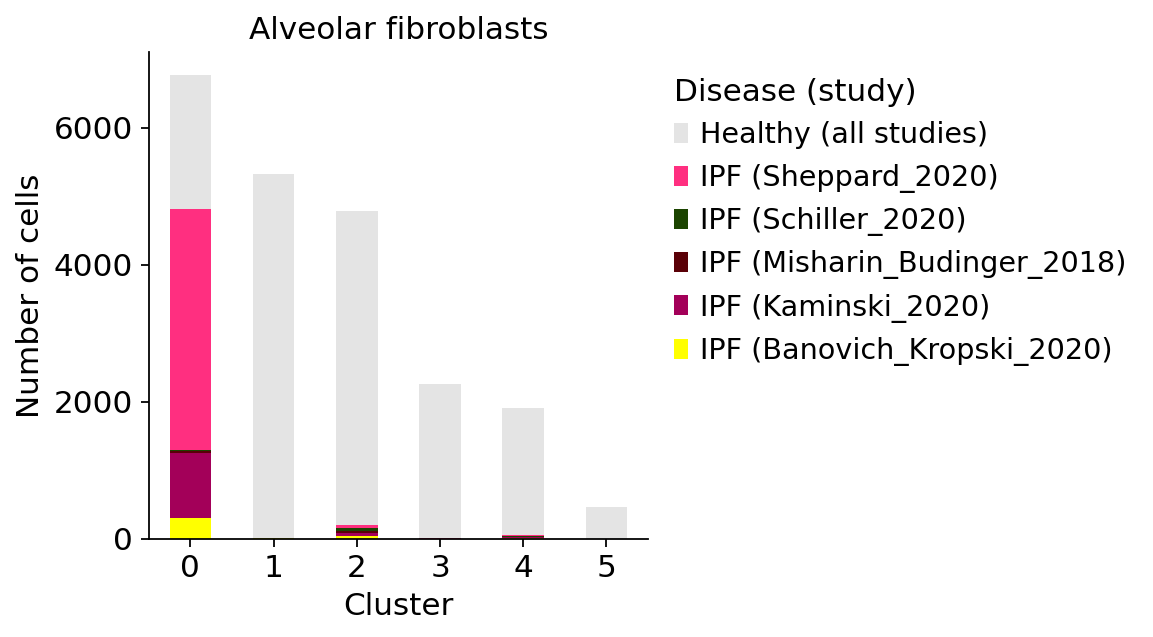

In [52]:
i = "leiden_0.3"
j = "condition_study"
df = adata_comb.obs.copy()
df_plot = pd.crosstab(df[i], df[j])  # , normalize="index")
df_plot = df_plot.loc[
    :,
    [col for col in df_plot.columns if not col.startswith("Healthy")]
    + ["Healthy (all studies)"],
]
# tvar = adata_comb.obs["leiden_0.3"].value_counts().index.tolist()
fig, ax = plt.subplots()
df_plot.plot(  # loc[tvar, study2color.keys()].plot(
    kind="bar",
    stacked=True,
    legend=False,
    color=disstudy2color,
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(
    handles[::-1],
    labels[::-1],
    bbox_to_anchor=(1, 1, 0, 0),
    ncol=1,
    frameon=False,
    title="Disease (study)",
)
leg._legend_box.align = "left"
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xlabel("Cluster")
plt.ylabel("Number of cells")
plt.grid(False)
plt.title("Alveolar fibroblasts")
plt.tick_params(axis="x", rotation=0)
FIGURES["7c_barplot_alv_fibs_cluster_IPF_study.png"] = fig
plt.show()

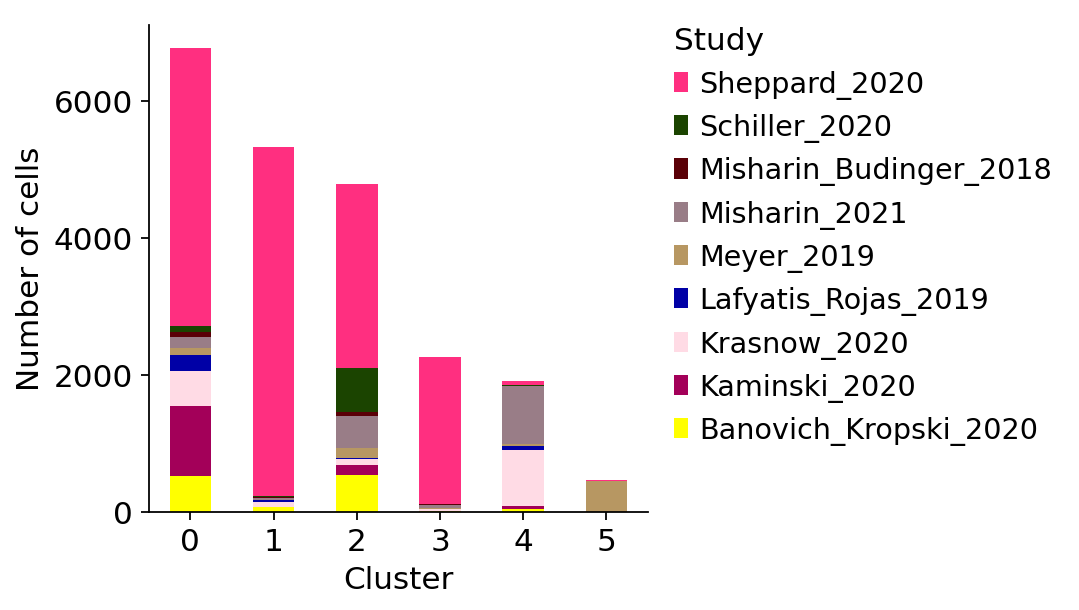

In [53]:
i = "leiden_0.3"
j = "study"
df = adata_comb.obs.copy()
df_plot = pd.crosstab(df[i], df[j])  # , normalize="index")
# tvar = adata_comb.obs["leiden_0.3"].value_counts().index.tolist()
fig, ax = plt.subplots()
df_plot.plot(kind="bar", stacked=True, legend=False, ax=ax, color=study2color)

handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(
    handles[::-1],
    labels[::-1],
    bbox_to_anchor=(1, 1.05, 0, 0),
    ncol=1,
    frameon=False,
    title="Study",
)
leg._legend_box.align = "left"
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xlabel("Cluster")
plt.ylabel("Number of cells")
ax.grid(False)
plt.xticks(rotation=0)
FIGURES["ED23b_barplot_alv_fibs_cluster_study"] = fig
plt.show()

don't know what this is for:

In [54]:
# InteractiveShell.ast_node_interactivity = "all"

Now looking at uncertainty

In [55]:
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True

Marker discovery

In [56]:
sc.tl.rank_genes_groups(adata_comb, groupby="leiden_0.3", method="wilcoxon")

In [57]:
# %%time
# for i in axis_xs:
#     print(f"\033[1;34m********************\033[0m {i}", end=" ")
#     print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
#     fname = str(sc.settings.figdir) + "/diffexp_" + i
#     print(fname)
#     if not os.path.isfile(fname + ".pickle"):
#         print("Running scanpy.tl.rank_genes_groups")
#         if not "rank_genes_" + i in adata_comb.uns.keys():
#             sc.tl.rank_genes_groups(
#                 adata_comb, groupby=i, key_added="rank_genes_" + i, method="wilcoxon"
#             )
#         a = adata_comb.uns["rank_genes_" + i]
#         with open(fname + ".pickle", 'wb') as handle:
#             pickle.dump(a, handle)
#         dedf = sc.get.rank_genes_groups_df(adata_comb, group=None, key="rank_genes_" + i)
#         print(f"Saving to: {fname}")
#         dedf.to_csv(fname + ".csv")
#     else:
#         print("Reloading results")
#         with open(fname + ".pickle", 'rb') as handle:
#             b = pickle.load(handle)
#         adata_comb.uns["rank_genes_" + i] = b
#         dedf = pd.read_csv(fname + ".csv")
#     print(dedf.iloc[:3, :])

In [58]:
# %%time
# de_dict_summary = {}
# for i in axis_xs:
#     print(f"\033[1;34m********************\033[0m {i}", end=" ")
#     dedf = sc.get.rank_genes_groups_df(adata_comb, group=None, key="rank_genes_" + i)
#     genes = list(set(dedf.loc[dedf["logfoldchanges"] > 0, "names"]))
#     res = pd.DataFrame(columns=genes, index=adata_comb.obs[i].cat.categories)
#     for clust in adata_comb.obs[i].cat.categories:
#         print(".", end="")
#         temp = adata_comb[adata_comb.obs[i].isin([clust]), genes].X > 0
#         res.loc[clust] = (temp.mean(0) * 100).round(1)
#         # for j in res.columns:
#         #     res.loc[clust,j] = (adata_comb[adata_comb.obs[i].isin([clust]),:][:,j].X > 0).mean(0)
#     res = res.T
#     res.columns = ["PCT_" + j for j in res.columns]
#     de_dict_summary[i] = res
#     print(" done!")
#     print(res.iloc[:10, :])

In [59]:
# for i in axis_xs:
#     print(f"\033[1;34m********************\033[0m {i}")
#     dedf = sc.get.rank_genes_groups_df(adata_comb, group=None, key="rank_genes_" + i)
#     de_dict_summary[i]["names"] = de_dict_summary[i].index.tolist()
#     # Adding to table
#     dedf = dedf.loc[dedf["logfoldchanges"] > 0, :]
#     dedf = dedf.merge(de_dict_summary[i], on="names")
#     dedf["scores_temp"] = dedf["scores"].abs()
#     dedf = dedf.sort_values(by=["group", "scores_temp"], ascending=[True, False])
#     del dedf["scores_temp"]
#     fname = str(sc.settings.figdir) + "/diffexp_" + i + "_filtered_stats"
#     print(f"Saving to: {fname}")
#     dedf.to_csv(fname + ".csv")

In [60]:
sc.tl.filter_rank_genes_groups(
    adata_comb,
    key="rank_genes_groups",
    key_added="rank_genes_groups_filtered",
    min_in_group_fraction=0.3,
    max_out_group_fraction=0.2,
)

In [61]:
# for i in axis_xs:
#     sc.tl.filter_rank_genes_groups(
#         adata_comb,
#         key="rank_genes_" + i,
#         key_added="rank_genes_" + i + "_fc2",
#         min_fold_change=2,
#     )
#     sc.pl.rank_genes_groups(
#         adata_comb,
#         key="rank_genes_" + i,
#         save=".png",
#     )
#     sc.pl.rank_genes_groups(adata_comb, key="rank_genes_" + i + "_fc2", save="_fc2.png")

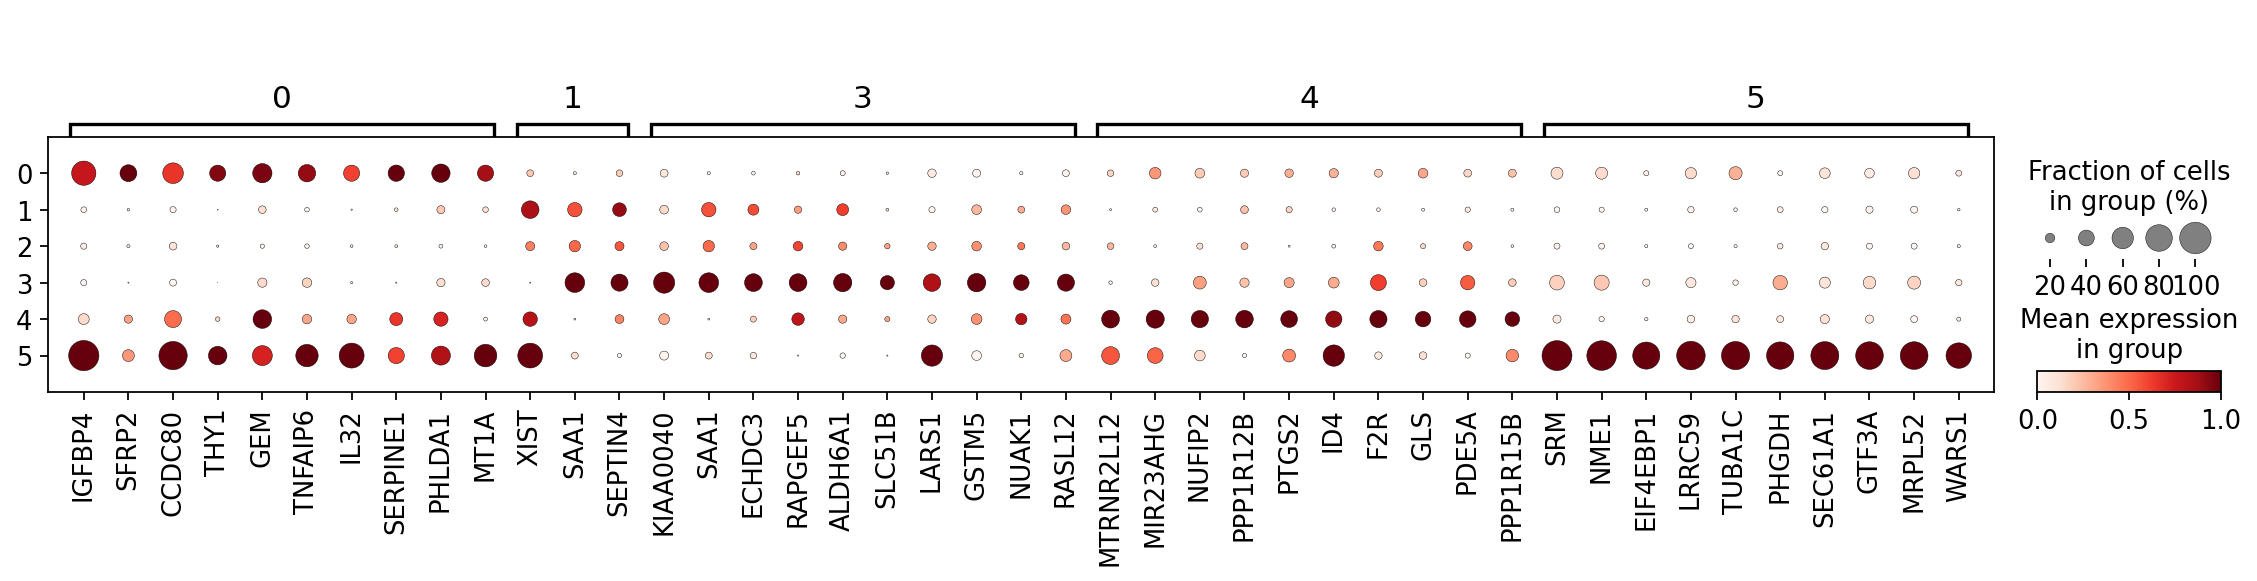

In [62]:
sc.pl.rank_genes_groups_dotplot(
    adata_comb,
    groupby="leiden_0.3",
    # dendrogram=dendrogram_plot,
    dendrogram=False,
    key="rank_genes_groups_filtered",
    n_genes=10,
    standard_scale="var",
)

Cluster 5 is small and looks very different from the rest, this might be specific to a single sample/subject and is therefore not interesting in understanding general trends. To see if that is the case, check subject diversity per cluster:

calculate subject entropy per cluster:

In [63]:
adata_comb = analysis.calculate_cluster_entropy(
    adata_comb, cluster_variable="leiden_0.3", obs_variable="subject_ID"
)

Storing entropy values in obs column entropy_subject_ID_leiden_0.3


print entropies per cluster:

In [64]:
adata_comb.obs.groupby("leiden_0.3").agg({"entropy_subject_ID_leiden_0.3": "first"})

,entropy_subject_ID_leiden_0.3
leiden_0.3,
0,2.978591
1,0.584720
2,2.500237
3,0.435958
4,1.484617
5,0.179521


Print largest single-donor fraction per cluster:

In [65]:
for cl in adata_comb.obs["leiden_0.3"].cat.categories:
    subj_counts = adata_comb.obs.loc[
        adata_comb.obs["leiden_0.3"] == cl, "subject_ID"
    ].value_counts()
    subj_perc = subj_counts / subj_counts.sum() * 100
    print(
        f"Cluster {cl}, largest subject proportion:",
        round(subj_perc.sort_values(ascending=False)[0], 1),
    )

Cluster 0, largest subject proportion: 22.1
Cluster 1, largest subject proportion: 89.0
Cluster 2, largest subject proportion: 25.8
Cluster 3, largest subject proportion: 92.6
Cluster 4, largest subject proportion: 42.9
Cluster 5, largest subject proportion: 96.3


As cluster 5 has subject entropy below the threshold used in the paper, we will exclude it:

In [66]:
adata_comb_no_cl5 = adata_comb[adata_comb.obs["leiden_0.3"] != "5", :].copy()

Select final markers based on markers from differential expression analysis, and literature-based IPF fibroblast markers.

In [67]:
markers = [
    "CCL2",
    "CTHRC1",
    "SERPINE1",
    "HIF1A",
    "COL1A1",
    "MMP19",
]

Generate variable that splits clusters by disease and study, for plotting:

In [68]:
adata_comb.obs["cluster_disease_study"] = [
    f"{x} ({y}, {z})" if x == "0" else x
    for x, y, z in zip(
        adata_comb.obs["leiden_0.3"],
        adata_comb.obs.condition,
        adata_comb.obs.study,
    )
]

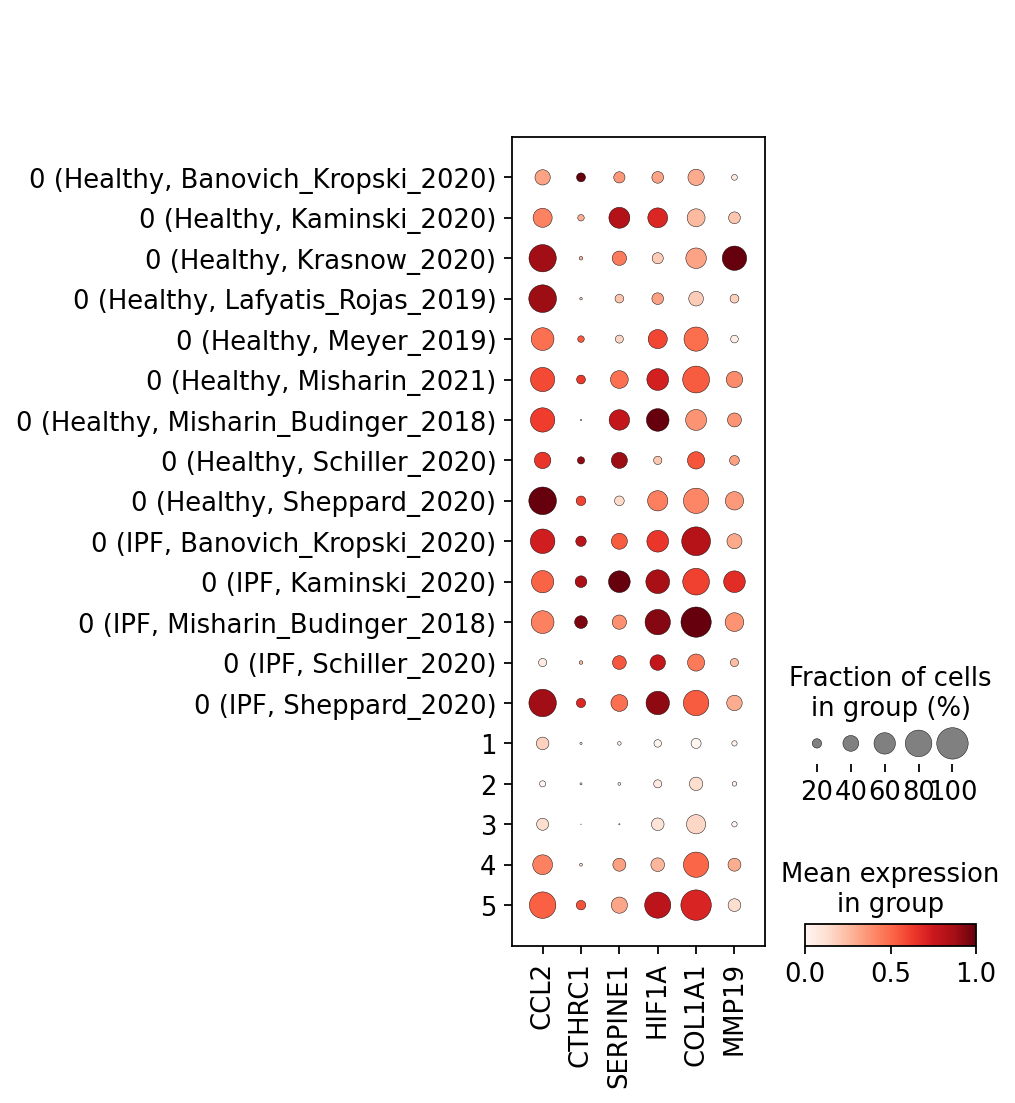

In [69]:
FIGURES["ED23c_dotplot_alv_fibs_IPF_markers_cluster_disease_study"] = sc.pl.dotplot(
    adata_comb,
    markers,
    groupby="cluster_disease_study",
    standard_scale="var",
    return_fig=True,
)
FIGURES["ED23c_dotplot_alv_fibs_IPF_markers_cluster_disease_study"].show()

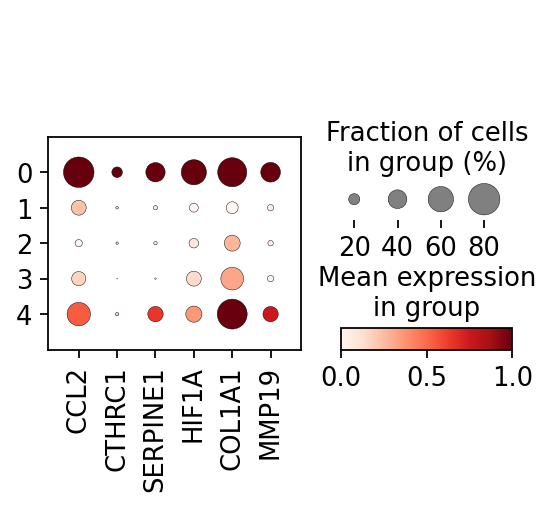

In [70]:
FIGURES["7d_dotplot_alv_fibs_IPF_markers"] = sc.pl.dotplot(
    adata_comb_no_cl5,
    markers,
    groupby="leiden_0.3",
    standard_scale="var",
    return_fig=True,
)
FIGURES["7d_dotplot_alv_fibs_IPF_markers"].show()

Check median library size per dataset, to see if this could explain low marker expression in Schiller IPF samples:

In [71]:
adata_comb.obs.groupby("study").agg({"total_counts": "median"})

,total_counts
study,
Banovich_Kropski_2020,1733.728516
Kaminski_2020,4262.500000
Krasnow_2020,1884.097534
Lafyatis_Rojas_2019,1581.796143
Meyer_2019,2311.054443
Misharin_2021,2062.458008
Misharin_Budinger_2018,1965.309448
Schiller_2020,537.000000
Sheppard_2020,2771.000000


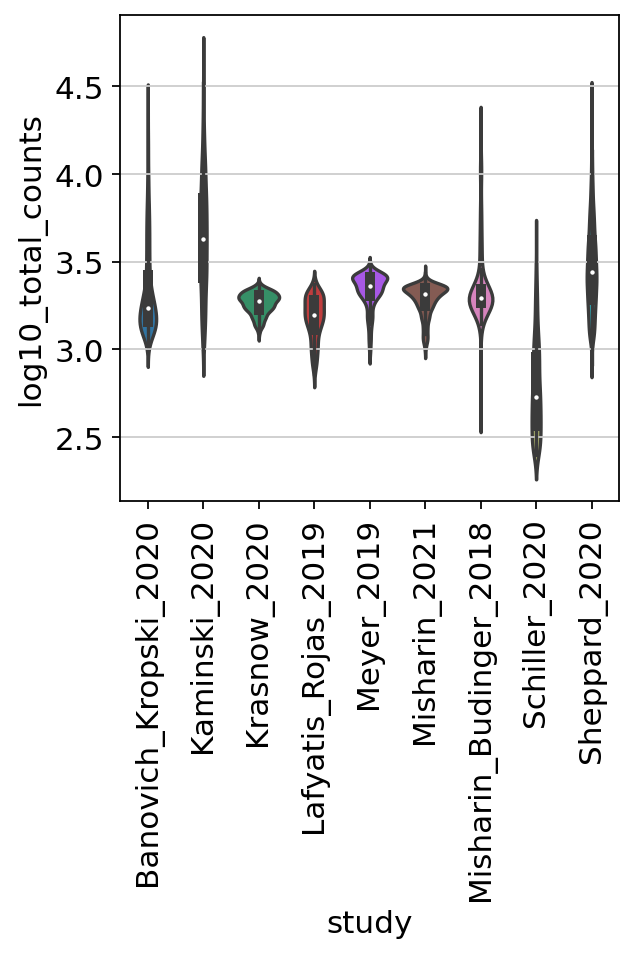

In [72]:
sns.violinplot(data=adata_comb.obs, x="study", y="log10_total_counts")
plt.xticks(rotation=90)
plt.show()

load full embedding with clean metadata for umap plot:

In [73]:
emb_full = sc.read_h5ad(path_hlca_full_emb)

In [74]:
emb_full.obs["alveolar_fibroblasts"] = "Other"
emb_full.obs.loc[adata_comb.obs.index, "alveolar_fibroblasts"] = "Alveolar fibroblasts"

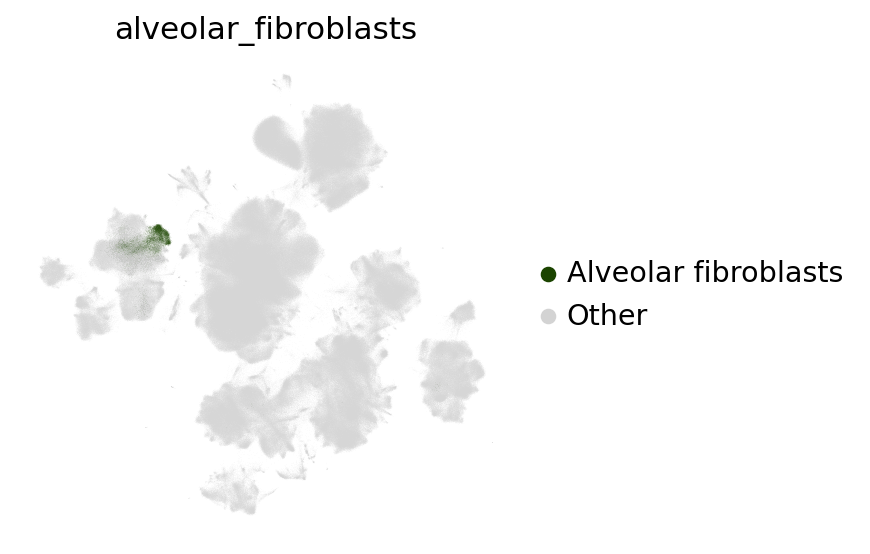

In [75]:
FIGURES["7b_umap_full_alv_fibs"] = sc.pl.umap(
    emb_full,
    color="alveolar_fibroblasts",
    palette={
        "Other": "lightgrey",
        "Alveolar fibroblasts": celltype_colors.loc["Alveolar fibroblasts", "color"],
    },
    frameon=False,
    return_fig=True,
)

# Save results:

Save differentially expressed gene results. We will save them only for the IPF enriched cluster, as this was the focus for the analysis:

In [76]:
degs = (
    sc.get.rank_genes_groups_df(adata_comb, group="0", key="rank_genes_groups_filtered")
    .dropna(how="any", axis=0)
    .set_index("names")
)

In [77]:
degs.to_csv(
    os.path.join(dir_dea_results, "DEGs_alv_fibs_IPFenriched_cluster_0_filtered.csv")
)

Save figures:

In [78]:
for figname, fig in FIGURES.items():
    print("Storing", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()

Storing 7b_umap_clusters
Storing 7c_barplot_alv_fibs_cluster_IPF_study.png
Storing ED23b_barplot_alv_fibs_cluster_study
Storing ED23c_dotplot_alv_fibs_IPF_markers_cluster_disease_study
Storing 7d_dotplot_alv_fibs_IPF_markers
Storing 7b_umap_full_alv_fibs
